(toolboxes:analyze_everything)=
# Analyze everything

This notebook demonstrates how to run a complete STRESS analysis in a few lines of code and produce all relevant output graphs.

In [16]:
import napari_stress
import napari
import numpy as np
from napari_stress import reconstruction, approximation, measurements, frame_by_frame, TimelapseConverter
import napari_process_points_and_surfaces as nppas
import vedo

from scipy import stats

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import napari_process_points_and_surfaces as nppas
import napari_segment_blobs_and_things_with_membranes as nsbatwm
from napari_stress import reconstruction
from napari_stress._preprocess import rescale
from skimage import filters
import copy

import tqdm
from sklearn import decomposition

## Config

For plotting:

In [2]:
save_figures_to_dir = True
colormap = 'seismic'

### Data dimensions
You need to set a few parameters pertaining to your data:

In [3]:
voxel_size_x = 1.0  # microns
voxel_size_y = 1.0  # microns
voxel_size_z = 1.93  # microns
target_voxel_size = 1.0  # microns

### Droplet reconstruction parameters

All of the parameters are explained in more detail [here](point_and_click:droplet_reconstruction).

In [4]:
n_smoothing_iterations = 10
n_points_first_guess = 256
n_tracing_iterations = 3
resampling_length = 1
fit_type = 'fancy'  # can be 'fancy' or 'quick'
edge_type = 'interior'  # can be 'interior' or 'surface'
trace_length = 15
sampling_distance = 1

*Hint:* Not sure whether the code is running probably? To show a progress bar for the processing of each timeframe, set the `verbose` parameter to `True`. You can also choose to run computations of multiple timepoints in parallel by using dask. Enable this by setting the `paralellize` parameter to `True`. This is the recommended setting.

*Note*: If you parallelize computation, you can observe the progress by navigating to `https://localhost:8787` in your browser to check the progress.

In [5]:
verbose = False
parallelize = False

### Stress analysis parameters
All of the used parameters are explained in more detail [here](point_and_click:stress_toolbox).

In [6]:
max_degree = 10  # spherical harmonics degree
n_quadrature_points = 434  # number of quadrature points to measure on (maximum is 5180)
gamma = 6.0  # interfacial tension of droplet

# Analysis

In [7]:
viewer = napari.Viewer(ndisplay=3)

In [8]:
example_data = napari_stress.get_droplet_4d()[0][0][0]
example_data.shape

(16, 30, 31)

In [9]:
n_frames = example_data.shape[0]

In [10]:
# rescale
scaling_factors = np.asarray([voxel_size_z, voxel_size_y, voxel_size_x])/target_voxel_size
rescaled_image = rescale(example_data,
                            scale_z=scaling_factors[0],
                            scale_y=scaling_factors[1],
                            scale_x=scaling_factors[2]).squeeze()


100%|██████████| 1/1 [00:00<00:00, 249.35it/s]


In [11]:

# Blur
rescaled_image = filters.gaussian(rescaled_image, sigma=1)


In [12]:

# convert to surface
binarized_image = nsbatwm.threshold_otsu(rescaled_image)
label_image = nsbatwm.connected_component_labeling(binarized_image)
surface = nppas.largest_label_to_surface(label_image)


In [13]:

# Smooth surface
surface_smoothed = nppas.filter_smooth_laplacian(
    surface, number_of_iterations=n_smoothing_iterations)

points_first_guess = nppas.sample_points_poisson_disk(
    surface_smoothed, number_of_points=256)
points = copy.deepcopy(points_first_guess)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [14]:

# repeat tracing `n_tracing_iterations` times
for i in range(n_tracing_iterations):
    resampled_points = reconstruction.toolbox._resample_pointcloud(
        points, sampling_length=resampling_length)

    traced_points, trace_vectors = reconstruction.trace_refinement_of_surface(
        rescaled_image,
        resampled_points,
        selected_fit_type=fit_type,
        selected_edge=edge_type,
        trace_length=trace_length,
        sampling_distance=sampling_distance,
        scale_x=1, scale_y=1, scale_z=1,
        show_progress=True)
    
    points = traced_points[0]

100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


In [15]:
viewer.add_points(points_first_guess, size=0.5, face_color='red')
viewer.add_points(traced_points[0], **traced_points[1])
viewer.add_image(rescaled_image)

<Image layer 'rescaled_image' at 0x1acaef3d550>

In [35]:
viewer.add_vectors(trace_vectors[0])

<Vectors layer 'Vectors' at 0x214804fec40>

In [43]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')

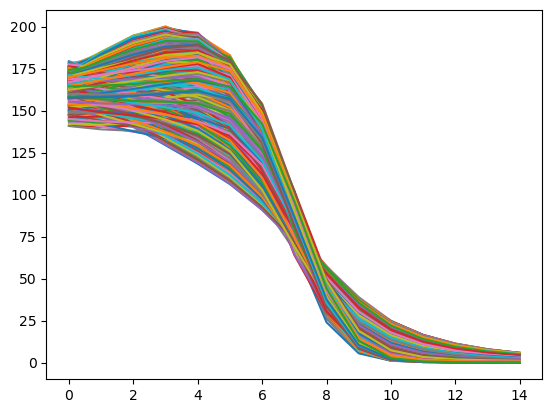

In [45]:
plt.plot(traced_points[1]['metadata']['intensity_profiles'].T)

In [20]:
pca = decomposition.PCA(n_components=2)
pca.fit_transform(pd.DataFrame(traced_points[1]['features']))


PCA(n_components=2)

,center,amplitude,slope,background_slope,offset,center_err,amplitude_err,slope_err,background_slope_err,offset_err,idx_of_border
0,7.484806,-174.733253,1.267018,-1.189806,169.536300,0.028411,2.611242,0.022901,0.639907,0.333738,7.484806
1,7.497600,-180.414839,1.364683,-0.525678,177.951859,0.046221,5.417960,0.055508,1.216566,1.297333,7.497600
2,7.484572,-177.392701,1.346520,-0.578153,174.697468,0.042872,4.920563,0.050133,1.095848,1.180057,7.484572
3,7.509900,-184.039738,1.105935,-2.907427,171.267267,0.080522,6.989640,0.044254,1.682458,0.805666,7.509900
4,7.497001,-191.144571,1.313072,-0.739895,187.968467,0.031249,4.561335,0.041721,0.899457,1.467443,7.497001
...,...,...,...,...,...,...,...,...,...,...,...
380,7.496771,-164.304623,1.368342,-0.227945,163.027534,0.031252,3.002470,0.046669,0.482960,1.127410,7.496771
381,7.568459,-183.168226,1.281756,-0.076394,183.226123,0.016679,2.073733,0.024697,0.283804,0.958340,7.568459
382,7.488753,-166.990721,1.300516,-0.383314,164.927642,0.022140,2.147661,0.029960,0.338523,0.798756,7.488753
383,7.546078,-174.941190,1.330251,-0.320848,173.319436,0.019951,2.365666,0.031649,0.326862,1.112294,7.546078
